In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np 
import pandas as pd

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil, floor

from smoother import Smoother
from sales_model import SalesModel

In [2]:
def scaler_max_column(data: pd.DataFrame) -> pd.DataFrame:
    return data.div(data.max(axis=0))

def scaler_max_global(data: pd.DataFrame) -> pd.DataFrame:
    return data.div(data.max(axis=None))

def scaler_diff_to_first(data: pd.DataFrame) -> pd.DataFrame:
    return data.sub(data.iloc[0, :])

def impute_by_column(data: pd.DataFrame) -> pd.DataFrame:
    return pd.concat(
        [pd.Series(Smoother().Impute(data[c].values)) for c in data.columns], 
        axis=1).set_axis(data.columns, axis=1)



#to-do 

program-wize
+ include price and wsd
+ max-scaler 
+ seasonality 
? events (пока не уверен что нужно)
+ visialization of decomposition 
+ price split local / global (очень актуально - из за этого проблема в модели)
+ equity to model
+ imputters (missing data)
+ smoothers
+ fix Imputer
- ROI calculation 

data-wize:
+ clean data (shit in CWSD)
+ inflation for media
+ check share of shelf (не актуально CWSD ~ Share(CWSD))
+ price local / global 
+ smooth media 

## Distributions

In [223]:
dist.Normal(0, 1).expand([12]).sample(key=key)

Array([ 1.0889369 ,  0.2524939 ,  2.3685842 , -0.14103898,  0.53609157,
        1.4111799 ,  0.77507305, -0.6683543 , -0.33454862,  0.02184686,
       -1.2621537 , -0.00761466], dtype=float32)

In [21]:
dist.LogNormal(1, 1).expand([1000]).sample(key=key).mean()

Array(4.3702526, dtype=float32)

<Axes: ylabel='Count'>

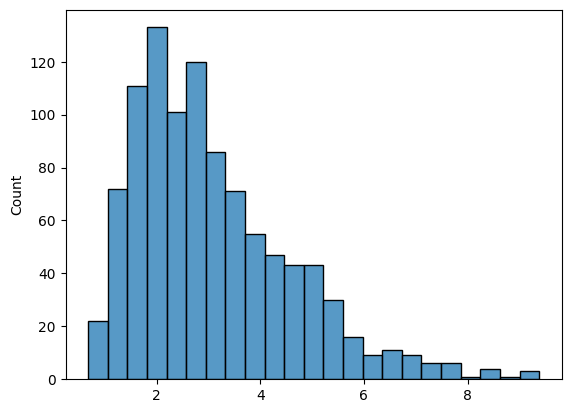

In [23]:
fig, ax = plt.subplots(1, 1)
key = jax.random.PRNGKey(3)
#sns.histplot(dist.Normal(0, .1).expand([1000]).sample(key=key))
#sns.histplot(dist.HalfNormal(.1).expand([500]).sample(key=key))
sns.histplot(dist.LogNormal(1, 0.5).expand([1000]).sample(key=key), ax=ax)
#sns.histplot(dist.Beta(2,2).expand([500]).sample(key=key))
#sns.histplot(dist.StudentT(3).expand([1000]).sample(key=key))

#ax.set_xlim(0,10)

## Tests

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

## Data Prep

In [3]:
data_folder = "../2024 danone/"
os.listdir("../2024 danone/")

['data.xlsx',
 'SY_CD_DY (numbers changed vs original).xlsx',
 'temp.csv',
 'Актибио.xlsx']

In [4]:
data = pd.read_excel(data_folder + 'data.xlsx')

<Axes: >

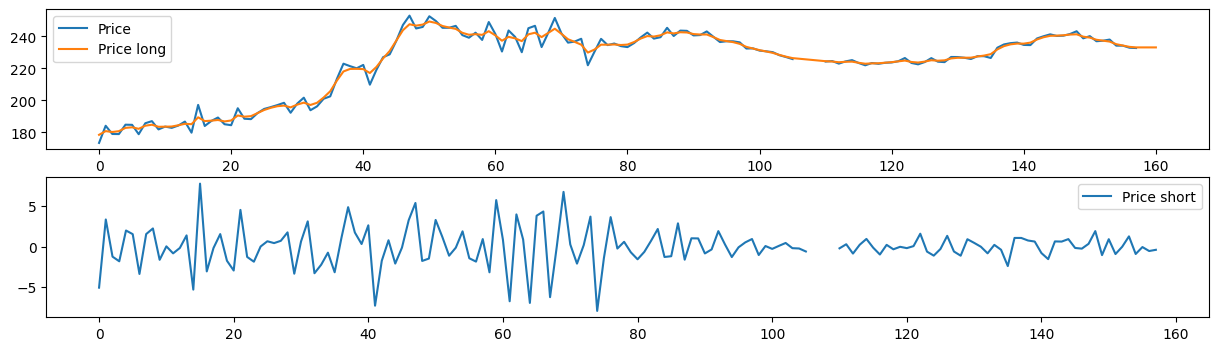

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(15,4))

data['Price long'] = Smoother().Smooth(data['Price'], method='kalman')
data['Price short'] = data['Price'] - data['Price long']

data[['Price', 'Price long']].plot.line(ax=axs[0])
data[['Price short']].plot.line(ax=axs[1])

In [6]:
camp_cols = ['TV Yoga', 'TV fig skates', 'TV Launch', 'TV 220 pack', 'TV Skates', 'TV NCP promo', 'OLV', 'Digital other ', 'OOH', 'Radio']
#price_cols = ['Price long', 'Price short']
price_cols = ['Price']
wsd_cols = ['CWSD']
sales_cols = ['Volume']
brand_cols = ['Brand']

data[camp_cols] = data[camp_cols].fillna(0)
data[price_cols + wsd_cols + sales_cols] = impute_by_column(data[price_cols + wsd_cols + sales_cols])

In [7]:
data

,date,TV Yoga,TV fig skates,TV Launch,TV 220 pack,TV Skates,TV NCP promo,OLV,Digital other,OOH,Radio,CWSD,Volume,Price,Brand,Price long,Price short
0,2021-06-21,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.322187e+05,1.925544e+06,0.0,0.0,2496.063477,283735.93750,173.381561,0.410760,178.451214,-5.069654
1,2021-06-28,6.350031e+06,0.0,0.0,0.0,0.0,0.0,3.400359e+06,1.722387e+06,0.0,0.0,2577.408936,285324.81250,184.113510,0.364349,180.767417,3.346085
2,2021-07-05,5.232049e+06,0.0,0.0,0.0,0.0,0.0,3.942284e+06,1.423433e+06,0.0,0.0,2550.270264,283286.21875,178.972672,0.381413,180.214675,-1.242006
3,2021-07-12,4.552183e+06,0.0,0.0,0.0,0.0,0.0,4.073557e+06,1.461453e+06,0.0,0.0,2465.096924,268178.84375,178.911987,0.481828,180.726833,-1.814848
4,2021-07-19,4.519352e+06,0.0,0.0,0.0,0.0,0.0,2.654426e+06,1.448619e+06,0.0,0.0,2498.497559,280317.28125,184.781586,0.490421,182.795048,1.986535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2024-06-17,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1691.386353,294024.71875,232.952545,0.482074,233.499726,-0.547186
157,2024-06-24,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1680.145142,296958.34375,232.762985,0.469950,233.159637,-0.396650
158,NaT,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1691.074829,298195.43750,233.159637,0.433673,233.159637,NaN
159,NaT,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1691.074829,298195.43750,233.159637,0.410466,233.159637,NaN


In [24]:
sales = scaler_max_column(data[sales_cols]).values

X ={
    #'brand': data[brand_cols].values,
    'media': scaler_max_global(data[camp_cols]).values, 
    'price': scaler_diff_to_first(scaler_max_column(data[price_cols])).values,
    'wsd': scaler_diff_to_first(scaler_max_column(data[wsd_cols])).values
}

brand = data['Brand'].values

## Model

In [93]:
def fix_seasonal(sample: dict):
    data_len = sample['base'].shape[-1]
    seasonal_len = sample['seasonal'].shape[-1]
    sample['seasonal'] = np.tile(sample['seasonal'], ceil(data_len / seasonal_len))[..., :data_len]
    return sample

def aggregate_sample(sample: dict):
    return {k: v.mean(axis=0) for k, v in sample.items()}

def to_pandas(sample: dict):
    return pd.concat({k: pd.DataFrame(v) for k, v in sample.items()}, axis=1)

In [95]:
model = SalesModel(seasonality=52).Fit(X=X, y=sales, show_progress=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [96]:
sample = model.SampleModel(X)
decomposition = to_pandas(fix_seasonal(aggregate_sample(sample)))

In [85]:
#decomposition['base'].to_csv("temp.csv")

In [177]:
decomposition

base     media                                                    \
            0         0         1         2         3         4         5   
0    0.394837  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.394155  0.007808  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.395177  0.010539  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.397255  0.011614  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.397148  0.012546  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
156  0.433837  0.000145  0.000033  0.000364  0.000678  0.016053  0.000207   
157  0.433010  0.000144  0.000032  0.000355  0.000598  0.013973  0.000205   
158  0.431709  0.000144  0.000032  0.000345  0.000533  0.012362  0.000204   
159  0.430721  0.000143  0.000032  0.000337  0.000480  0.011070  0.000202   
160  0.430970  0.000142  0.000031  0.000328  0.000436  0.010006  0.000200   

                                                    y  
            6         7         8         9         0  
0    0.000146  0.002394  0.000000  0.000000  0.398102  
1    0.003808  0.003311  0.000000  0.000000  0.408862  
2    0.006019  0.003538  0.000000  0.000000  0.415846  
3    0.007313  0.003832  0.000000  0.000000  0.419533  
4    0.006511  0.004053  0.000000  0.000000  0.421350  
..        ...       ...       ...       ...       ...  
156  0.000121  0.000167  0.000240  0.000323  0.452106  
157  0.000120  0.000166  0.000235  0.000314  0.448955  
158  0.000119  0.000165  0.000230  0.000305  0.446547  
159  0.000119  0.000164  0.000225  0.000297  0.444705  
160  0.000118  0.000163  0.000221  0.000289  0.443128  

[161 rows x 12 columns]

## Visualization

In [98]:
components = ['base', 'media', 'price', 'seasonal', 'wsd']

<Axes: ylabel='Count'>

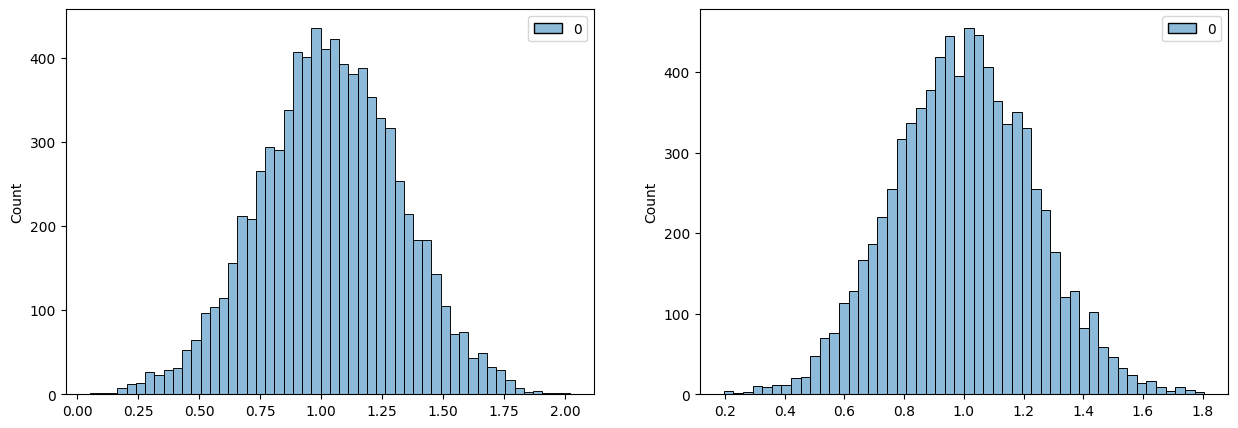

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(model.mcmc.get_samples()['wsd_beta'], ax=axs[0])
sns.histplot(model.mcmc.get_samples()['price_beta'], ax=axs[1])

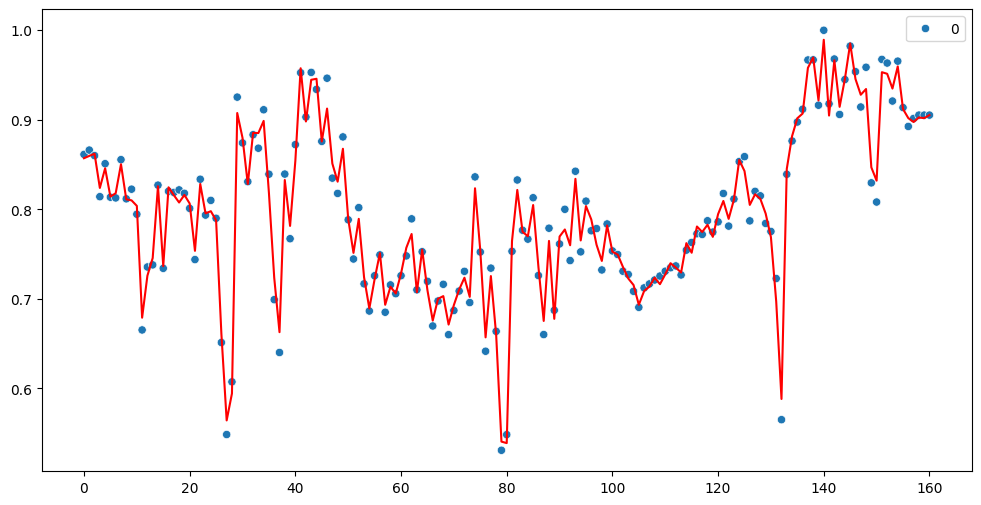

In [111]:
def PlotFit(decomposition, sales):
    #fig, axs = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])
    fig, axs = plt.subplots(1, 1, figsize=(12, 6))

    decomposition[components].sum(axis=1).plot(color='red')
    sns.scatterplot(sales)
    
PlotFit(decomposition, sales)

KeyError: "['price' 'seasonal' 'wsd'] not in index"

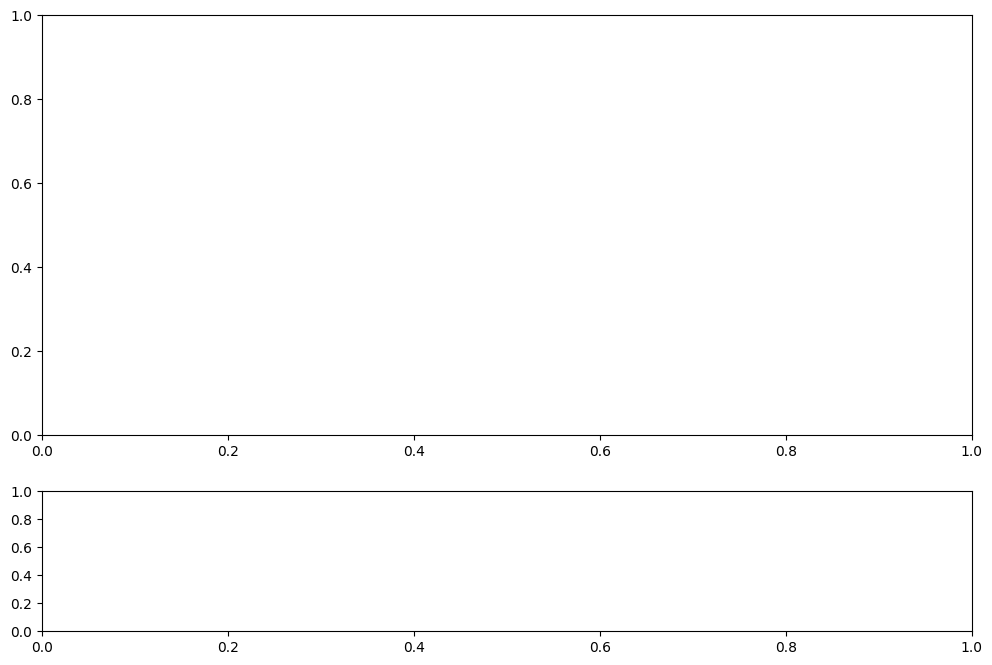

In [178]:
def PlotMediaImpact(decomposition, media_df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])

    pd.concat(
        [decomposition[['media']].sum(axis=1), decomposition[['base', 'price', 'seasonal', 'wsd']].sum(axis=1)], 
        axis=1)\
    .set_axis(['Media', 'Structural'], axis=1)\
    .plot.area(ax=axs[0], linewidth=0)
    sns.scatterplot(pd.DataFrame(sales, columns=['Actual sales']), ax=axs[0], color='grey', alpha=0.3)

    media_df.plot.area(ax=axs[1], linewidth=0, stacked=False)
    
PlotMediaImpact(decomposition, data[camp_cols])

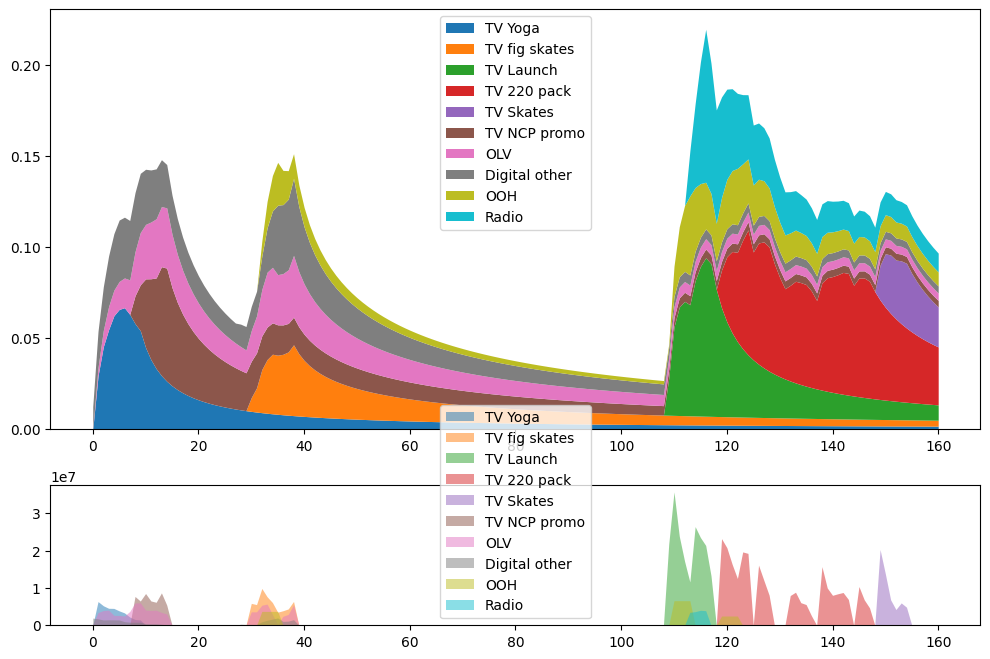

In [102]:
def PlotMediaDecomposition(decomposition, media_df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])

    decomposition['media'].set_axis(media_df.columns, axis=1).plot.area(ax=axs[0], linewidth=0, stacked=True)

    media_df.plot.area(ax=axs[1], linewidth=0, stacked=False)
    
PlotMediaDecomposition(decomposition, data[camp_cols])

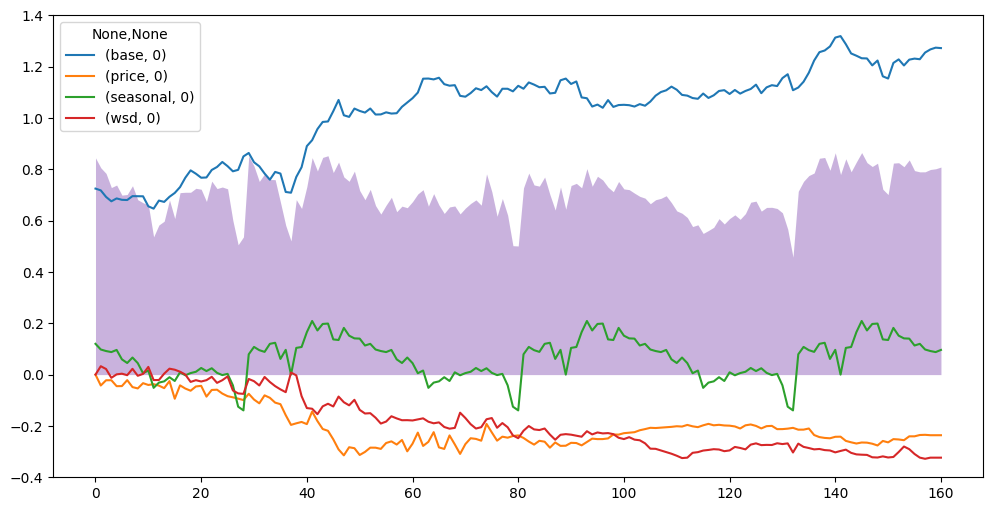

In [104]:
def PlotStructural(decomposition):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    decomposition[['base', 'price', 'seasonal', 'wsd']].plot.line(ax=ax)
    #decomposition[['brand_base']].plot.line(ax=ax)
    decomposition[['base', 'price', 'seasonal', 'wsd']].sum(axis=1).plot.area(linewidth=0, alpha=0.5, ax=ax)
    ax.set_ylim(
        floor(10 * decomposition[['base', 'price', 'seasonal', 'wsd']].min(axis=None)) / 10, 
        ceil(10 * decomposition[['base', 'price', 'seasonal', 'wsd']].max(axis=None)) / 10, 
    )
    
PlotStructural(decomposition)

## Brand rprt

In [122]:
model.mcmc.get_samples().keys()

dict_keys(['base', 'base_drift_scale', 'base_init', 'brand_base', 'brand_base_drift_scale', 'brand_base_init', 'brand_noise_scale', 'media', 'media_beta', 'media_retention', 'price', 'price_beta', 'sales_noise_scale', 'seasonal', 'wsd', 'wsd_beta'])

<Axes: ylabel='Count'>

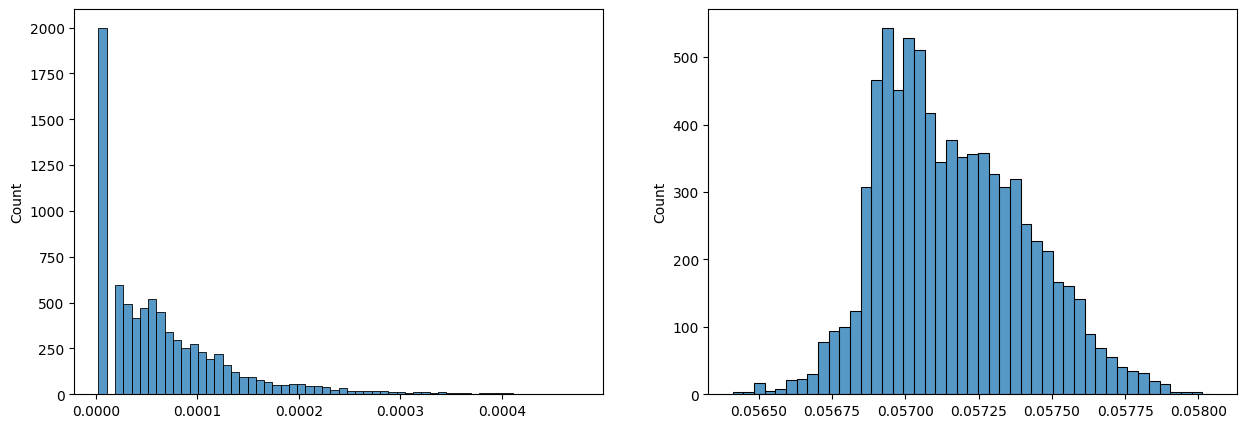

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(model.mcmc.get_samples()['brand_base_drift_scale'], ax=axs[0])
sns.histplot(model.mcmc.get_samples()['brand_noise_scale'], ax=axs[1])


<Axes: >

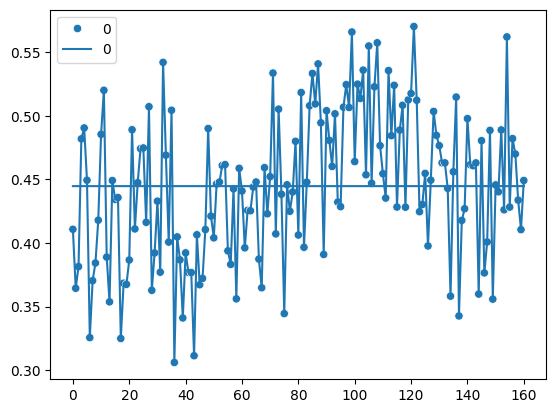

In [156]:
sns.lineplot(model.mcmc.get_samples()['brand_base'].mean(axis=0))
sns.scatterplot(X['brand'])
sns.lineplot(decomposition['brand'])

## ROI

In [62]:
tmp_med = decomposition['media'].sum(axis=0)
tmp_med.index = camp_cols
tmp_med

TV Yoga           1.354095
TV fig skates     1.157521
TV Launch         1.407895
TV 220 pack       2.104026
TV Skates         0.282050
TV NCP promo      1.709207
OLV               1.722329
Digital other     1.722281
OOH               1.027496
Radio             1.185420
dtype: float32

In [63]:
roi = tmp_med / data[camp_cols].sum(axis=0)
roi / roi.max()

TV Yoga           0.519820
TV fig skates     0.276074
TV Launch         0.091747
TV 220 pack       0.103116
TV Skates         0.063961
TV NCP promo      0.437939
OLV               0.254451
Digital other     0.876697
OOH               0.254837
Radio             1.000000
dtype: float64

# Brand Model

In [134]:
from brand_model import BrandModel

In [140]:
brand

array([0.4107597 , 0.36434929, 0.38141347, 0.48182847, 0.49042107,
       0.44928874, 0.32556087, 0.37034802, 0.38422966, 0.41787036,
       0.48540091, 0.52003683, 0.38885663, 0.35369116, 0.44908046,
       0.43429568, 0.43569657, 0.32488114, 0.36834311, 0.36744352,
       0.38659019, 0.4890138 , 0.41103294, 0.44741979, 0.47419977,
       0.4747001 , 0.41621028, 0.50715285, 0.36276299, 0.39213654,
       0.43285918, 0.37700512, 0.54199184, 0.46901517, 0.4006908 ,
       0.50436399, 0.30602   , 0.40476542, 0.38670135, 0.34102875,
       0.39221571, 0.37682148, 0.37675763, 0.3113322 , 0.40644284,
       0.3671319 , 0.37211075, 0.4105161 , 0.48996539, 0.42111726,
       0.40401471, 0.44641708, 0.44786436, 0.46092621, 0.46161659,
       0.39380621, 0.38312175, 0.44251522, 0.35604697, 0.45868479,
       0.44084561, 0.39615588, 0.4256218 , 0.42531777, 0.44399077,
       0.44792102, 0.38729207, 0.36475559, 0.45923709, 0.42292735,
       0.45217564, 0.53357563, 0.40712642, 0.50520934, 0.43829

In [135]:
brand_model = BrandModel().Fit(X, brand, show_progress=True)
sample = brand_model.SampleModel(X)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [125]:
decomposition = to_pandas(aggregate_sample(sample))
decomposition

base     media                                                    \
            0         0         1         2         3         4         5   
0    0.394837  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.394155  0.007808  0.000000  0.000000  0.000000  0.000000  0.000000   
2    0.395177  0.010539  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.397255  0.011614  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.397148  0.012546  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
156  0.433837  0.000145  0.000033  0.000364  0.000678  0.016053  0.000207   
157  0.433010  0.000144  0.000032  0.000355  0.000598  0.013973  0.000205   
158  0.431709  0.000144  0.000032  0.000345  0.000533  0.012362  0.000204   
159  0.430721  0.000143  0.000032  0.000337  0.000480  0.011070  0.000202   
160  0.430970  0.000142  0.000031  0.000328  0.000436  0.010006  0.000200   

                                                    y  
            6         7         8         9         0  
0    0.000146  0.002394  0.000000  0.000000  0.398102  
1    0.003808  0.003311  0.000000  0.000000  0.408862  
2    0.006019  0.003538  0.000000  0.000000  0.415846  
3    0.007313  0.003832  0.000000  0.000000  0.419533  
4    0.006511  0.004053  0.000000  0.000000  0.421350  
..        ...       ...       ...       ...       ...  
156  0.000121  0.000167  0.000240  0.000323  0.452106  
157  0.000120  0.000166  0.000235  0.000314  0.448955  
158  0.000119  0.000165  0.000230  0.000305  0.446547  
159  0.000119  0.000164  0.000225  0.000297  0.444705  
160  0.000118  0.000163  0.000221  0.000289  0.443128  

[161 rows x 12 columns]

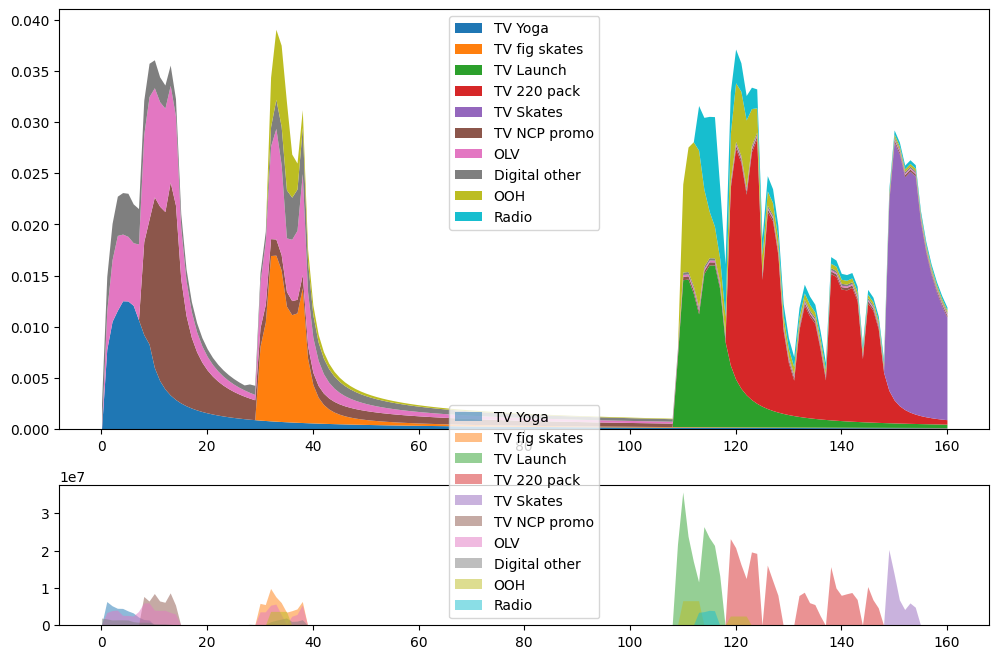

In [126]:
def PlotMediaDecomposition(decomposition, media_df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])

    decomposition['media'].set_axis(media_df.columns, axis=1).plot.area(ax=axs[0], linewidth=0, stacked=True)

    media_df.plot.area(ax=axs[1], linewidth=0, stacked=False)
    
PlotMediaDecomposition(decomposition, data[camp_cols])

<Axes: >

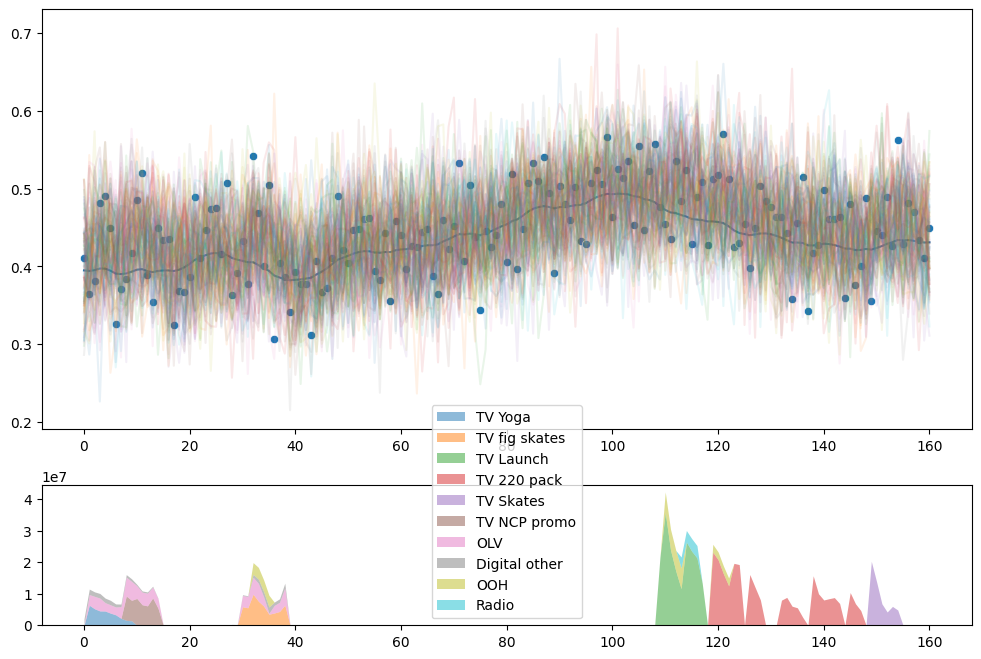

In [123]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])

sns.lineplot(sample['base'].mean(axis=0), ax=axs[0])
#sns.lineplot(sample['y'].mean(axis=0), ax=axs[0])
for i in range(100):
    sns.lineplot(sample['y'][i], ax=axs[0], alpha=0.1)
sns.scatterplot(brand, ax=axs[0])

data[camp_cols].plot.area(linewidth=0, alpha=0.5, ax=axs[1])

In [ ]:
def PlotMediaDecomposition(decomposition, media_df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])

    decomposition['media'].set_axis(media_df.columns, axis=1).plot.area(ax=axs[0], linewidth=0, stacked=True)

    media_df.plot.area(ax=axs[1], linewidth=0, stacked=False)
    
PlotMediaDecomposition(decomposition, data[camp_cols])

In [ ]:
def PlotMediaImpact(decomposition, media_df):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])

    pd.concat(
        [decomposition[['media']].sum(axis=1), decomposition[['base', 'price', 'seasonal', 'wsd']].sum(axis=1)], 
        axis=1)\
    .set_axis(['Media', 'Structural'], axis=1)\
    .plot.area(ax=axs[0], linewidth=0)
    sns.scatterplot(pd.DataFrame(sales, columns=['Actual sales']), ax=axs[0], color='grey', alpha=0.3)

    media_df.plot.area(ax=axs[1], linewidth=0, stacked=False)
    
PlotMediaImpact(decomposition, data[camp_cols])

# Scaler test

In [203]:
from Modeller import Scaler

In [201]:
data[]

,date,TV Yoga,TV fig skates,TV Launch,TV 220 pack,TV Skates,TV NCP promo,OLV,Digital other,OOH,Radio,CWSD,Volume,Price,Brand
0,2021-06-21,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,1.322187e+05,1.925544e+06,0.0,0.0,2496.063477,283735.93750,173.381561,5.341463
1,2021-06-28,6.350031e+06,0.0,0.0,0.0,0.000000e+00,0.0,3.400359e+06,1.722387e+06,0.0,0.0,2577.408936,285324.81250,184.113510,5.379747
2,2021-07-05,5.232049e+06,0.0,0.0,0.0,0.000000e+00,0.0,3.942284e+06,1.423433e+06,0.0,0.0,2550.270264,283286.21875,178.972672,5.452381
3,2021-07-12,4.552183e+06,0.0,0.0,0.0,0.000000e+00,0.0,4.073557e+06,1.461453e+06,0.0,0.0,2465.096924,268178.84375,178.911987,6.111111
4,2021-07-19,4.519352e+06,0.0,0.0,0.0,0.000000e+00,0.0,2.654426e+06,1.448619e+06,0.0,0.0,2498.497559,280317.28125,184.781586,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2024-05-27,0.000000e+00,0.0,0.0,0.0,5.986787e+06,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1799.113037,303372.43750,238.071411,4.835714
154,2024-06-03,0.000000e+00,0.0,0.0,0.0,4.843655e+06,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1773.428711,318058.65625,234.254745,3.791045
155,2024-06-10,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1726.625244,300968.09375,234.251495,5.046875
156,2024-06-17,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1691.386353,294024.71875,232.952545,5.029412


<Axes: >

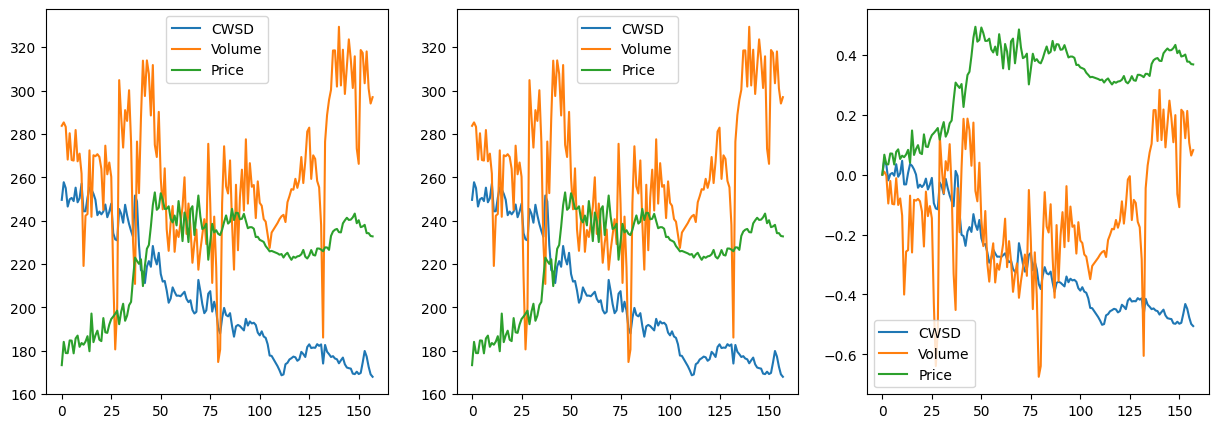

In [236]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ddd =data[['CWSD', 'Volume', 'Price']]
ddd.loc[:, 'CWSD'] = ddd['CWSD'] / 10
ddd.loc[:, 'Volume'] = ddd['Volume'] / 1000


ddd.plot.line(ax=ax[0])
scaler = Scaler(scaling='min_max', centering='first', mode='global').Fit(ddd)
trans = scaler.Transform(ddd)
trans.plot.line(ax=ax[2])
scaler.InverseTransform(trans).plot.line(ax=ax[1])

In [12]:
{
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }

{'sin_order_1': 3.928773447456944e-15,
 'cos_order_1': 1.0,
 'sin_order_2': 7.857546894913888e-15,
 'cos_order_2': 1.0,
 'sin_order_3': -1.019005173792452e-13,
 'cos_order_3': 1.0,
 'sin_order_4': 1.5715093789827776e-14,
 'cos_order_4': 1.0,
 'sin_order_5': 1.3333070495890074e-13,
 'cos_order_5': 1.0,
 'sin_order_6': -2.038010347584904e-13,
 'cos_order_6': 1.0,
 'sin_order_7': 3.685619272970467e-13,
 'cos_order_7': 1.0,
 'sin_order_8': 3.143018757965555e-14,
 'cos_order_8': 1.0,
 'sin_order_9': -3.057015521377356e-13,
 'cos_order_9': 1.0,
 'sin_order_10': 2.666614099178015e-13,
 'cos_order_10': 1.0}

# vis

In [7]:
data = pd.read_excel("../2024 danone/for_decomp_chart.xlsx", index_col='date')

In [17]:
struct = ['Brand modeled', 'LongPriceIndex', 'ShortPriceIndex', 'Demand', 'WSD']
data[struct] < 0

,Brand modeled,LongPriceIndex,ShortPriceIndex,Demand,WSD
date,,,,,
2021-06-21,False,False,False,False,False
2021-06-28,False,True,True,True,False
2021-07-05,True,True,True,True,False
2021-07-12,True,True,False,True,True
2021-07-19,True,True,True,True,False
...,...,...,...,...,...
2024-05-27,True,True,True,False,False
2024-06-03,True,True,True,False,False
2024-06-10,True,True,True,False,False


In [77]:
data_positive.columns

Index(['Brand modeled', 'LongPriceIndex', 'ShortPriceIndex', 'Demand', 'WSD',
       'base'],
      dtype='object')

In [75]:
sns.color_palette("Set1", len(data_positive.columns))

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2)]

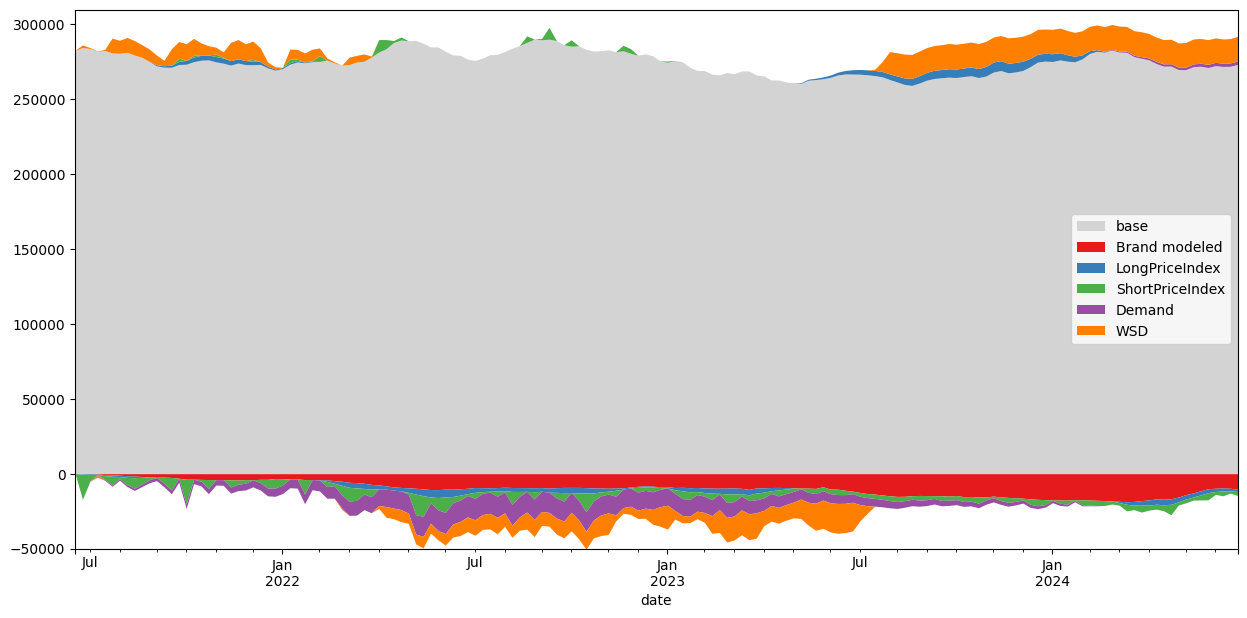

In [83]:
data_negative = data[struct].where(data[struct] < 0, 0)
data_positive = data[struct].where(data[struct] > 0, 0)
data_positive['base'] = data['base']
data_positive = data_positive[['base'] + struct]

fig, ax = plt.subplots(1,1, figsize=(15,7))

ch1 = data_positive.plot.area(ax=ax, linewidth=0, ylim=(-50000, 310000), color= ['lightgrey'] + sns.color_palette("Set1", len(data_positive.columns)-1))
h, l = ax.get_legend_handles_labels()
ch2 = data_negative.plot.area(ax=ax, linewidth=0, ylim=(-50000, 310000), color=sns.color_palette("Set1", 10))

ax.legend(handles=h)